In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
import time
from IPython import display
%matplotlib inline

from helper import *

/Users/mattfeng/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from gridworld import gameEnv as game_env

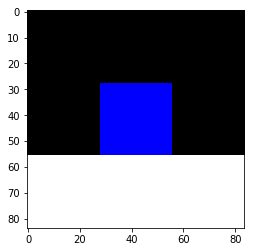

In [3]:
env = game_env(partial=True, size=9)

In [4]:
class QNetwork(object):
    def __init__(self, h_size, rnn_cell, scope, lr):
        # Receive frames from the game, flattened as an array,
        # then resize and process it through four convolutional layers.
        # Note that scalar_input can take in more than one frame at a time.
        self.scalar_input = tf.placeholder(shape=[None, 84 * 84 * 3], dtype=tf.float32)
        self.image_in = tf.reshape(self.scalar_input, shape=[-1, 84, 84, 3])
        self.conv1 = slim.convolution2d(
            inputs=self.image_in, num_outputs=32,
            kernel_size=[8, 8], stride=[4, 4], padding='VALID',
            biases_initializer=None, scope="{}_conv1".format(scope)
        )
        self.conv2 = slim.convolution2d(
            inputs=self.conv1, num_outputs=64,
            kernel_size=[4, 4], stride=[2, 2], padding='VALID',
            biases_initializer=None, scope="{}_conv2".format(scope)
        )
        self.conv3 = slim.convolution2d(
            inputs=self.conv2, num_outputs=64,
            kernel_size=[3, 3], stride=[1, 1], padding='VALID',
            biases_initializer=None, scope="{}_conv3".format(scope)
        )
        self.conv4 = slim.convolution2d(
            inputs=self.conv3, num_outputs=h_size,
            kernel_size=[7, 7], stride=[1, 1], padding='VALID',
            biases_initializer=None, scope="{}_conv4".format(scope)
        )
        
        self.train_length = tf.placeholder(dtype=tf.int32)
        # Take the output from the conv4 and send it to a recurrent layer.
        # Input must be reshaped into [batch x trace x units] for RNN processing
        # and then returned to [batch x units] when sent through the upper levels.
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[])
        self.conv_flat = tf.reshape(slim.flatten(self.conv4),
                                   [self.batch_size, self.train_length, h_size])
        self.state_in = rnn_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(
            inputs=self.conv_flat, cell=rnn_cell, dtype=tf.float32,
            initial_state=self.state_in, scope="{}_rnn".format(scope)
        )
        self.rnn = tf.reshape(self.rnn, shape=[-1, h_size])
        # The output from the recurrent layer is then split into
        # separate Value and Advantage streams
        self.stream_A, self.stream_V = tf.split(self.rnn, 2, axis=1)
        self.AW = tf.Variable(tf.random_normal([h_size // 2, 4]))
        self.VW = tf.Variable(tf.random_normal([h_size // 2, 1]))
        self.Advantage = tf.matmul(self.stream_A, self.AW)
        self.Value = tf.matmul(self.stream_V, self.VW)
        
        self.salience = tf.gradients(self.Advantage, self.image_in)
        
        # Combine the Value and Advantage streams to get final Q-values.
        self.Advantage_μ = tf.reduce_mean(self.Advantage, axis=1, keep_dims=True)
        self.Qout = self.Value + tf.subtract(self.Advantage, self.Advantage_μ)
        self.predict = tf.argmax(self.Qout, axis=1)
        
        # Obtain the loss by taking the sum of squares difference between
        # the target and prediction Q values
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_1h = tf.one_hot(self.actions, 4, dtype=tf.float32)
        
        # Computes the Q value predicted for the action that was actually taken.
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_1h), axis=1)
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # In order to only propogate accurate gradients through the network, we
        # will mask the first half of the losses for each trace as per
        # Lample and Chaplot, 2016.
        self.maskA = tf.zeros([self.batch_size, self.train_length // 2])
        self.maskB = tf.ones([self.batch_size, self.train_length // 2])
        self.mask = tf.concat([self.maskA, self.maskB], axis=1)
        self.mask = tf.reshape(self.mask, [-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = self.trainer.minimize(self.loss)
        

## Experience Replay

In [5]:
class ExperienceBuffer():
    def __init__(self, buffer_size=1000):
        # Buffer contains a list of episodes, where each episode is a
        # list of 5-tuples (s, a, r, s1, d)
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1 + len(self.buffer)) - self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self, batch_size, trace_length):
        sampled_episodes = random.sample(self.buffer, batch_size)
        sampled_traces = []
        for episode in sampled_episodes:
            point = np.random.randint(0, len(episode) + 1 - trace_length)
            sampled_traces.append(episode[point:point + trace_length])
        sampled_traces = np.array(sampled_traces)
        return np.reshape(sampled_traces, [batch_size * trace_length, 5])

## Hyperparameters

In [6]:
path = "./drqn"
h_size = 512
lr = 0.001

## Run and Visualize the Model

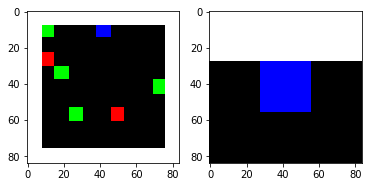

KeyboardInterrupt: 

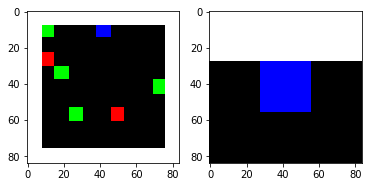

In [7]:
tf.reset_default_graph()

cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)
mainQN = QNetwork(h_size, cell, "main", lr)
targetQN = QNetwork(h_size, cellT, "target", lr)

saver = tf.train.Saver(max_to_keep=5)

with tf.Session() as sess:
    print("[i] Loading model...")
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    while True:
        ep_buffer = []
        # Reset the environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        r_all = 0
        j = 0
        # Reset the recurrent layer's hidden state
        state = (np.zeros([1, h_size]), np.zeros([1, h_size]))
        
        # The Q-Network
        while not d:
            j += 1
            
            plt.figure(3)
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.imshow(env.renderEnv(full=True))
            plt.subplot(1, 2, 2)
            plt.imshow(env.renderEnv())
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            # Choose an action greedily from the Q-network
            feed_dict = {
                mainQN.scalar_input: [s / 255.0],
                mainQN.train_length: 1,
                mainQN.state_in: state,
                mainQN.batch_size: 1
            }
            
            a, state1 = sess.run([mainQN.predict, mainQN.rnn_state],
                                 feed_dict=feed_dict)
            a = a[0]
            
            # Get the next step in the game environment
            s1, r, d = env.step(a)
            s1 = processState(s1)
            s = s1
            state = state1
            
            time.sleep(1)
            
        cont = input(">> ")
        if cont == "n":
            break
        